<a href="https://colab.research.google.com/github/yohanesnuwara/DASLab/blob/main/notebooks/DASDetectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q nptdms==0.25.0 # Older version

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

     |████████████████████████████████| 153kB 3.9MB/s 


In [ ]:
# Connect to Goo Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access JMA catalogue

In [ ]:
# Access DASLab repository
!git clone 'https://github.com/yohanesnuwara/DASLab'

sys.path.append('/content/DASLab')
from TDMS_Functions import getInfoFromJMA

Cloning into 'DASLab'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 255 (delta 145), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (255/255), 10.44 MiB | 8.80 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [ ]:
def readJMA_csv(filepath):
  df = pd.read_csv(filepath, header=0, dtype=str,
                  names=['Date', 'Time', 'TimeErr', 'Lat', 'LatErr', 'Lon', 'LonErr',
                         'Dep', 'DepErr', 'Mag', 'Loc'])
  df = df.fillna('nan')

  # Convert to Pandas datetime
  df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
  df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f').dt.time

  # Edit magnitude, delete 'v'
  mag = [df.Mag.values[i][:3] for i in range(len(df))]
  mag = [np.nan if x=='na' else x for x in mag]
  
  mags = []
  for i in mag:
    if len(i)==3:
      # It's a magnitude, convert to float
      x = np.float(i)
    else:
      # It has unusual information e.g. 'na', convert to nan
      x = np.nan
    mags.append(x)

  df['Mag'] = mags

  # Convert other columns to float
  df['Lat'] = [float(df.Lat.values[i]) for i in range(len(df))]
  df['Lon'] = [float(df.Lon.values[i]) for i in range(len(df))]
  df['Dep'] = [float(df.Dep.values[i]) for i in range(len(df))]

  # Drop all NaN values of Lat and Lon
  catalog_df = df[['Date', 'Time', 'Lat', 'Lon', 'Dep', 'Mag', 'Loc']].\
               dropna(subset=['Lat']).reset_index(drop=True)
  return catalog_df

In [ ]:
# Read catalog into dataframe
filepath = '/content/DASLab/data/JMA_original_2020Jan_2020Apr.csv'

catalog_df = readJMA_csv(filepath)
catalog_df

,Date,Time,Lat,Lon,Dep,Mag,Loc
0,2020-01-18,15:14:53.810000,41.067,139.280,19.4,1.4,W OFF AOMORI PREF k
1,2020-01-18,15:16:03.290000,34.696,138.667,15.0,0.9,SOUTHERN SURUGA BAY REG A
2,2020-01-18,15:18:44.950000,34.838,140.692,63.3,1.4,SE OFF BOSO PENINSULA k
3,2020-01-18,15:22:12.370000,24.288,122.849,54.8,1.5,NW OFF ISHIGAKIJIMA IS k
4,2020-01-18,15:29:07.990000,34.107,135.942,23.7,0.1,SOUTHERN NARA PREF k
...,...,...,...,...,...,...,...
42968,2020-04-02,23:47:22.630000,32.144,131.675,43.0,0.3,HYUGANADA REGION A
42969,2020-04-02,23:51:10.410000,41.376,140.494,154.0,NaN,TSUGARU STRAIT REGION k
42970,2020-04-02,23:51:51.130000,29.982,130.503,45.2,2.9,NEAR AMAMI-OSHIMA ISLAND K
42971,2020-04-02,23:52:16.010000,38.340,142.127,33.5,2.3,E OFF MIYAGI PREF K


In [ ]:
"""
	Date	      Time	          Lat	    Lon	    Dep	  Mag	Loc
	2020-02-07	21:18:12.160000	35.574	140.266	43.0	0.5	CENTRAL CHIBA PREF A
	2020-03-27	02:49:33.260000	36.664	140.596	0.8	 -1.0	NORTHERN IBARAKI PREF a 
  2020-02-12	19:37:18.830000	37.312	141.359	86.9	5.4	OFF FUKUSHIMA PREF K  
  2020-03-25	11:49:21	      48.985	157.692	56.6	7.5	FAR FIELD S
"""

'\n\tDate\t      Time\t          Lat\t    Lon\t    Dep\t  Mag\tLoc\n\t2020-02-07\t21:18:12.160000\t35.574\t140.266\t43.0\t0.5\tCENTRAL CHIBA PREF A\n\t2020-03-27\t02:49:33.260000\t36.664\t140.596\t0.8\t -1.0\tNORTHERN IBARAKI PREF a \n  2020-02-12\t19:37:18.830000\t37.312\t141.359\t86.9\t5.4\tOFF FUKUSHIMA PREF K  \n  2020-03-25\t11:49:21\t      48.985\t157.692\t56.6\t7.5\tFAR FIELD S\n'

In [ ]:
!pip -q install utm
import utm

In [ ]:
# Convert Lat-Long to UTM
lat, lon = catalog_df.Lat.values, catalog_df.Lon.values

a, b, c, d = utm.from_latlon(lat, lon, 54, 'N')
utmE = a / 1000
utmN = b / 1000   

catalog_df['UTM_E'] = utmE
catalog_df['UTM_N'] = utmN

catalog_df

,Date,Time,Lat,Lon,Dep,Mag,Loc,UTM_E,UTM_N
0,2020-01-18,15:14:53.810000,41.067,139.280,19.4,1.4,W OFF AOMORI PREF k,355.488933,4547.619934
1,2020-01-18,15:16:03.290000,34.696,138.667,15.0,0.9,SOUTHERN SURUGA BAY REG A,286.304580,3841.808782
2,2020-01-18,15:18:44.950000,34.838,140.692,63.3,1.4,SE OFF BOSO PENINSULA k,471.839163,3855.121360
3,2020-01-18,15:22:12.370000,24.288,122.849,54.8,1.5,NW OFF ISHIGAKIJIMA IS k,-1362.702507,2810.283890
4,2020-01-18,15:29:07.990000,34.107,135.942,23.7,0.1,SOUTHERN NARA PREF k,33.264683,3785.590052
...,...,...,...,...,...,...,...,...,...
42968,2020-04-02,23:47:22.630000,32.144,131.675,43.0,0.3,HYUGANADA REGION A,-381.109247,3594.754008
42969,2020-04-02,23:51:10.410000,41.376,140.494,154.0,NaN,TSUGARU STRAIT REGION k,457.687309,4580.621498
42970,2020-04-02,23:51:51.130000,29.982,130.503,45.2,2.9,NEAR AMAMI-OSHIMA ISLAND K,-515.446031,3363.606119
42971,2020-04-02,23:52:16.010000,38.340,142.127,33.5,2.3,E OFF MIYAGI PREF K,598.490489,4244.140742


In [ ]:
def hypoDistance(cord1, cord2):
  x1, y1, z1 = cord1
  x2, y2, z2 = cord2
  return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)

def epiDistance(cord1, cord2):
  x1, y1, _ = cord1
  x2, y2, _ = cord2
  return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def incAngle(cord1, cord2):
  _, _, z1 = cord1
  _, _, z2 = cord2
  hypo_dist = hypoDistance(cord1, cord2)
  dip = np.rad2deg(np.arcsin((z2 - z1) / hypo_dist))
  return 90 - dip

def azimuth(cord1, cord2):
  x1, y1, _ = cord1
  x2, y2, _ = cord2
  return np.rad2deg(np.arctan((x2 -x1)/(y2 -y1)))

In [ ]:
# Ichihara site coordinate
ichi_cord = (426.7747392664837, 3930.0408808721904, -0.8)

# Calculate hypo-distance, epi-distance, incident angle, azimuth
hypo_cord = [(catalog_df.UTM_E.values[i], catalog_df.UTM_N.values[i], 
              catalog_df.Dep.values[i]) for i in range(len(catalog_df))]

hypo_dist = [hypoDistance(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]

epi_dist = [epiDistance(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]

inc_angle = [incAngle(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]

azim = [azimuth(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]

catalog_df['HypoDistance'] = hypo_dist
catalog_df['EpiDistance'] = epi_dist
catalog_df['IncAngle'] = inc_angle
catalog_df['Azimuth'] = azim

catalog_df

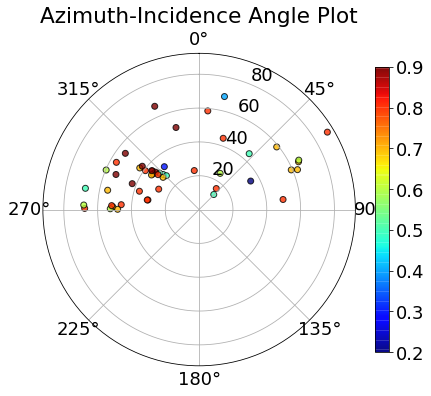

In [ ]:
dfx = catalog_df[(catalog_df.Mag<1) & (catalog_df.Dep<50) & (catalog_df.HypoDistance<50)]

angle = dfx.IncAngle.values
azi = dfx.Azimuth.values

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111, projection='polar')
im = ax.scatter(azi*np.pi/180, angle, lw=1, c=dfx.Mag.values, 
           cmap='jet', alpha=0.8, edgecolor='black')
f.colorbar(im, shrink=0.75)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # clockwise
ax.grid(True)
ax.set_title('Azimuth-Incidence Angle Plot', pad=15)

plt.show()

In [ ]:
!conda create --name pygmt-env gmt
!conda activate pygmt-env
!pip install pygmt

/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [ ]:
getInfoFromJMA('/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200220_035300.000.tdms', catalog_df)


Info for file connected whole_UTC_20200220_035300.000
Date           : 2020-02-20T00:00:00.000000000
Time           : 12:53:08.270000
Magnitude      : 4.3
Lat, Lon, Depth: (35.396, 140.311, 27.7)
Location       : .0V  KUJUKURI COAST BOSO PEN  K


In [ ]:
tdms_filepth = '/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200220_035300.000.tdms'

getInfoFromJMA(tdms_filepth, catalog_df, print_info=False)

,Date,Time,Lat,Lon,Dep,Mag,Loc
17878,2020-02-20,12:53:08.270000,35.396,140.311,27.7,4.3,.0V KUJUKURI COAST BOSO PEN K


In [ ]:
# catalog = pd.read_csv('/content/DASLab/data/Earthquake_events_catalog.csv')

# catalog

In [ ]:
from TDMS_Functions import getInfoFromJMA

filepath = '/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200220_035300.000.tdms'
catalog_csv_path = '/content/DASLab/data/Earthquake_events_catalog.csv'

getInfoFromJMA(filepath, catalog_csv_path)

Info for file connected whole_UTC_20200220_035300.000
Date       : 20/02/2020
Time       : 12:53:08
Magnitude  : 4.3
Station    : KUJUKURI COAST BOSO PEN


In [ ]:
import glob
import os

filepth = "/content/drive/MyDrive/RITE_Yohanes/20210209/data"
read_files = sorted(glob.glob(os.path.join(filepth, "*.tdms")))

for files in read_files:
  getInfoFromJMA(files, catalog_csv_path, print_info=True)
  print('\n')

Info for file connected whole_UTC_20200220_035300.000
Date       : 20/02/2020
Time       : 12:53:08
Magnitude  : 4.3
Station    : KUJUKURI COAST BOSO PEN


Info for file connected whole_UTC_20200220_063300.000
Date       : 20/02/2020
Time       : 15:33:37
Magnitude  : 2.8
Station    : KUJUKURI COAST BOSO PEN
Info for file connected whole_UTC_20200220_063300.000
Date       : 20/02/2020
Time       : 15:33:27
Magnitude  : 2.0
Station    : CENTRAL CHIBA PREF K


Info for file connected whole_UTC_20200221_223200.000
Date       : 22/02/2020
Time       : 07:32:41
Magnitude  : 1.4
Station    : SOUTHERN BOSO PENINSULA


Info for file connected whole_UTC_20200226_132300.000
Date       : 26/02/2020
Time       : 22:23:53
Magnitude  : 1.3
Station    : KUJUKURI COAST BOSO PEN


No info for file connected whole_UTC_20200226_132400.000. Check in catalog.


Info for file connected whole_UTC_20200228_183800.000
Date       : 29/02/2020
Time       : 03:38:41
Magnitude  : 0.8
Station    : KUJUKURI COAST BO

In [ ]:
filepth = "/content/drive/MyDrive/RITE_Yohanes/20210209/data"
read_files = sorted(glob.glob(os.path.join(filepth, "*.tdms")))

df_select = []
for files in read_files:
  df = getInfoFromJMA(files, catalog_csv_path, print_info=False)
  df_select.append(df)

df_select = pd.concat(df_select).reset_index(drop=True)
df_select

No info for file connected whole_UTC_20200226_132400.000. Check in catalog.


,ID,Date,Time,Magnitude,Epi-Distance,Depth,Distance,UTM_E,UTM_N,Notes,TDMSDatetime
0,17789,20/02/2020,12:53:08,4.3,16.71,27.7,32.35,437.43,3917.18,KUJUKURI COAST BOSO PEN,20/02/2020 12:53:00
1,17874,20/02/2020,15:33:37,2.8,17.35,27.5,32.52,437.88,3916.73,KUJUKURI COAST BOSO PEN,20/02/2020 15:33:00
2,17873,20/02/2020,15:33:27,2.0,17.38,45.6,48.80,411.11,3937.59,CENTRAL CHIBA PREF K,20/02/2020 15:33:00
3,19856,22/02/2020,07:32:41,1.4,18.83,21.2,28.36,428.76,3911.36,SOUTHERN BOSO PENINSULA,22/02/2020 07:32:00
4,22664,26/02/2020,22:23:53,1.3,19.89,30.1,36.08,445.37,3922.89,KUJUKURI COAST BOSO PEN,26/02/2020 22:23:00
5,23937,29/02/2020,03:38:41,0.8,18.26,29.9,35.03,444.76,3926.67,KUJUKURI COAST BOSO PEN,29/02/2020 03:38:00
6,24658,01/03/2020,07:22:11,1.4,16.54,28.1,32.61,437.43,3917.40,KUJUKURI COAST BOSO PEN,01/03/2020 07:22:00
7,25980,03/03/2020,17:54:24,3.1,13.86,22.6,26.51,440.60,3928.69,CENTRAL CHIBA PREF K,03/03/2020 17:54:00


In [ ]:
dfx = df_select.iloc[:,:-1]

dfx

,ID,Date,Time,Magnitude,Epi-Distance,Depth,Distance,UTM_E,UTM_N,Notes
0,17789,20/02/2020,12:53:08,4.3,16.71,27.7,32.35,437.43,3917.18,KUJUKURI COAST BOSO PEN
1,17874,20/02/2020,15:33:37,2.8,17.35,27.5,32.52,437.88,3916.73,KUJUKURI COAST BOSO PEN
2,17873,20/02/2020,15:33:27,2.0,17.38,45.6,48.80,411.11,3937.59,CENTRAL CHIBA PREF K
3,19856,22/02/2020,07:32:41,1.4,18.83,21.2,28.36,428.76,3911.36,SOUTHERN BOSO PENINSULA
4,22664,26/02/2020,22:23:53,1.3,19.89,30.1,36.08,445.37,3922.89,KUJUKURI COAST BOSO PEN
5,23937,29/02/2020,03:38:41,0.8,18.26,29.9,35.03,444.76,3926.67,KUJUKURI COAST BOSO PEN
6,24658,01/03/2020,07:22:11,1.4,16.54,28.1,32.61,437.43,3917.40,KUJUKURI COAST BOSO PEN
7,25980,03/03/2020,17:54:24,3.1,13.86,22.6,26.51,440.60,3928.69,CENTRAL CHIBA PREF K


In [ ]:
A = [13e3, 1.5e3, 30, 60, 60, 50, 200, 5e3]

dfx = df_select[['Magnitude', 'Depth', 'UTM_E', 'UTM_N']]

# Input amplitude into dataframe
dfx['Ap'] = A

# Ichihara site coordinate
ichi_cord = (426.7747392664837, 3930.0408808721904, -0.8)

# Calculate hypo-distance, epi-distance, incident angle, azimuth
hypo_cord = [(dfx.UTM_E.values[i], dfx.UTM_N.values[i], dfx.Depth.values[i])\
             for i in range(len(dfx))]
hypo_dist = [hypoDistance(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]
epi_dist = [epiDistance(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]
inc_angle = [incAngle(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]
azim = [azimuth(ichi_cord, hypo_cord[i]) for i in range(len(hypo_cord))]

dfx['HypoDistance'] = hypo_dist
dfx['EpiDistance'] = epi_dist
dfx['IncAngle'] = inc_angle
dfx['Azimuth'] = azim

dfx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Magnitude,Depth,UTM_E,UTM_N,Ap,HypoDistance,EpiDistance,IncAngle,Azimuth
0,4.3,27.7,437.43,3917.18,13000.0,33.033117,16.701402,30.370905,-39.641804
1,2.8,27.5,437.88,3916.73,1500.0,33.187292,17.335119,31.489485,-39.838224
2,2.0,45.6,411.11,3937.59,30.0,49.551319,17.388883,20.544009,-64.269748
3,1.4,21.2,428.76,3911.36,60.0,28.929510,18.786074,40.494426,-6.066188
4,1.3,30.1,445.37,3922.89,60.0,36.765865,19.922822,32.811960,-68.965556
5,0.8,29.9,444.76,3926.67,50.0,35.739648,18.298427,30.796632,-79.384516
6,1.4,28.1,437.43,3917.40,200.0,33.294691,16.532588,29.772227,-40.128234
7,3.1,22.6,440.60,3928.69,5000.0,27.212547,13.891102,30.694928,-84.419284


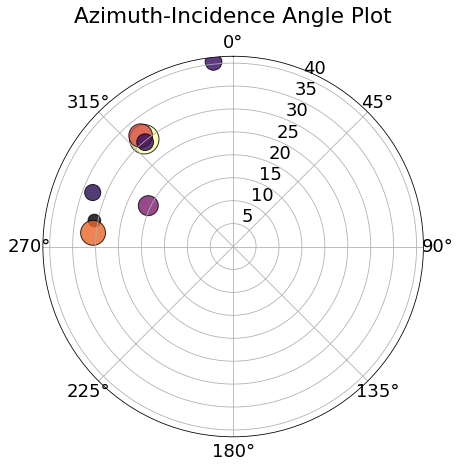

In [ ]:
time = dfx.IncAngle.values
azi = dfx.Azimuth

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111, projection='polar')
# ax.plot(azi*np.pi/180, time, marker='o', color='black', markerfacecolor='limegreen')
ax.scatter(azi*np.pi/180, time, c=dfx.Magnitude, s=dfx.Magnitude*200, lw=1, 
           cmap='inferno', alpha=0.8, edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # clockwise
ax.grid(True)
ax.set_title('Azimuth-Incidence Angle Plot', pad=15)

# ax.set_ylabel('Time', color='crimson')
# ax.tick_params(axis='y', colors='crimson')

plt.show()

## Analysis

In [ ]:
file1 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200220_035300.000.tdms"
file2 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200220_063300.000.tdms"
file3 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200221_223200.000.tdms"
file4 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200226_132300.000.tdms"
file5 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200226_132400.000.tdms"
file6 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200228_183800.000.tdms"
file7 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200229_222200.000.tdms"
file8 = "/content/drive/MyDrive/RITE_Yohanes/20210209/data/connected whole_UTC_20200303_085400.000.tdms"

In [ ]:
df_das.t1.values[-1]

46.713

In [ ]:
def scatter(df, xcol, ycol, zcol=None, marker_color="blue", 
            title="Crossplot", xlabel="X", ylabel="Y", 
            regression=False, start_id=0, end_id=-1):
  
  from scipy.optimize import curve_fit

  if zcol==None:
    plt.scatter(df[xcol], df[ycol], c=marker_color)
  if zcol!=None:
    plt.scatter(df[xcol], df[ycol], c=df[zcol])
    plt.colorbar()

  if regression==True:
    # Linear regression on scatter plot
    def linear(x,a,b): return a*x+b
    x = df[xcol].values[start_id:end_id]
    y = df[ycol].values[start_id:end_id]
    [a,b], pcov = curve_fit(linear, x, y)

    xfit = np.sort(x)
    yfit = linear(xfit, a, b)
    plt.plot(xfit, yfit, color='red', label='y={:.4f}x+{:.4f}'.format(a,b))
    plt.legend(fontsize=12)

  # plt.grid()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)    

In [ ]:
filepth = '/content/P_BC_file3.csv'
df1 = pd.read_csv(filepth)

filepth = '/content/S_BC_file3.csv'
df2 = pd.read_csv(filepth)

df = df1.copy()
df['t2'] = df2['t1']
df['A2'] = df2['A1']

df

,D,t1,A1,t2,A2
0,0.000000,45.950,2.774540,50.160,6.465075
1,1.020952,45.967,2.524553,50.160,5.860728
2,2.041905,45.967,2.230217,50.160,5.728054
3,3.062857,46.298,2.692197,50.083,5.367811
4,4.083810,46.298,4.879564,50.083,5.803361
...,...,...,...,...,...
732,747.337145,45.914,51.959476,49.998,22.503795
733,748.358097,45.897,49.410392,49.999,21.921421
734,749.379050,45.897,49.418429,50.000,19.205413
735,750.400002,45.897,46.779946,50.000,18.729602


In [ ]:
df["tsmintp"] = df.t2 - df.t1
df["Ap/As"] = df.A1 / df.A2
df["logAp"] = np.log10(df.A1)
df["logAs"] = np.log10(df.A2)

df

,D,t1,A1,t2,A2,tsmintp,Ap/As,logAp,logAs
0,0.000000,45.950,2.774540,50.160,6.465075,4.210,0.429158,0.443191,0.810574
1,1.020952,45.967,2.524553,50.160,5.860728,4.193,0.430758,0.402184,0.767952
2,2.041905,45.967,2.230217,50.160,5.728054,4.193,0.389350,0.348347,0.758007
3,3.062857,46.298,2.692197,50.083,5.367811,3.785,0.501545,0.430107,0.729797
4,4.083810,46.298,4.879564,50.083,5.803361,3.785,0.840817,0.688381,0.763680
...,...,...,...,...,...,...,...,...,...
732,747.337145,45.914,51.959476,49.998,22.503795,4.084,2.308921,1.715665,1.352256
733,748.358097,45.897,49.410392,49.999,21.921421,4.102,2.253978,1.693818,1.340869
734,749.379050,45.897,49.418429,50.000,19.205413,4.103,2.573151,1.693889,1.283424
735,750.400002,45.897,46.779946,50.000,18.729602,4.103,2.497648,1.670060,1.272529


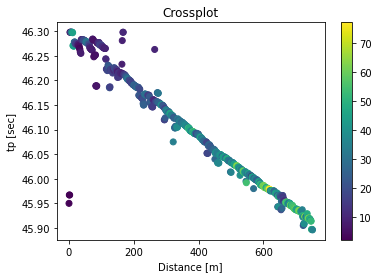

In [ ]:
scatter(df, "D", "t1", "A1", xlabel="Distance [m]", ylabel="tp [sec]")

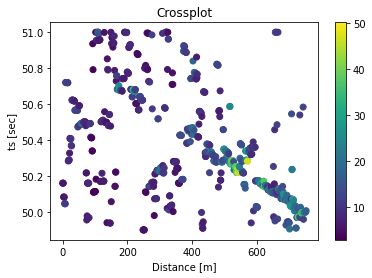

In [ ]:
scatter(df, "D", "t2", "A2", xlabel="Distance [m]", ylabel="ts [sec]")

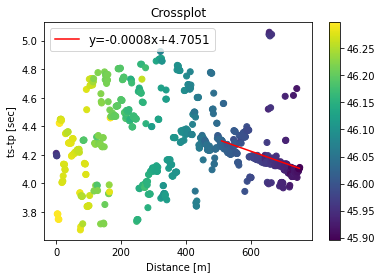

In [ ]:
scatter(df, "D", "tsmintp", "t1", xlabel="Distance [m]", ylabel="ts-tp [sec]", 
        regression=True, start_id=500, end_id=-1)

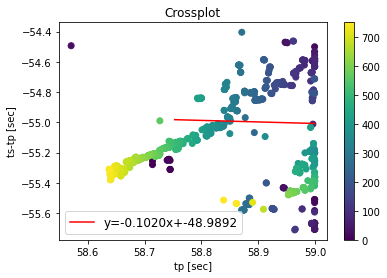

In [ ]:
scatter(df, "t1", "tsmintp", "D", xlabel="tp [sec]", ylabel="ts-tp [sec]", 
        regression=True, start_id=100, end_id=500)

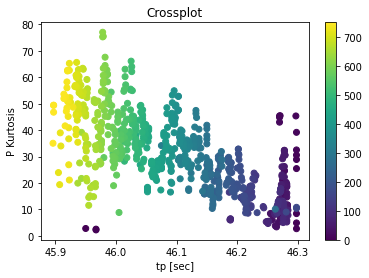

In [ ]:
scatter(df, "t1", "A1", "D", xlabel="tp [sec]", ylabel="P Kurtosis")

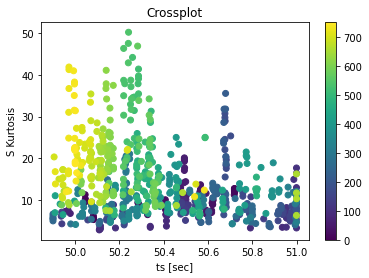

In [ ]:
scatter(df, "t2", "A2", "D", xlabel="ts [sec]", ylabel="S Kurtosis")

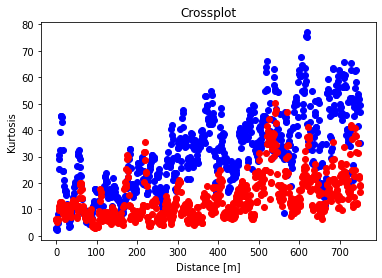

In [ ]:
scatter(df, "D", "A1", xlabel="Distance [m]", ylabel="Kurtosis")
scatter(df, "D", "A2", xlabel="Distance [m]", ylabel="Kurtosis", marker_color="red")
# plt.xlim(0,300)
# plt.ylim(0,40)

(750.0, 0.0)

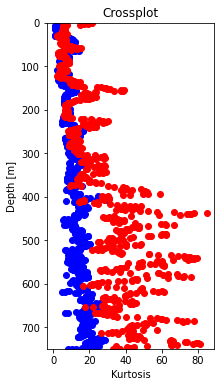

In [ ]:
plt.figure(figsize=(3,6))
scatter(df, "A1", "D", xlabel="Kurtosis", ylabel="Depth [m]")
scatter(df, "A2", "D", xlabel="Kurtosis", ylabel="Depth [m]", marker_color="red")
plt.ylim(750,0)

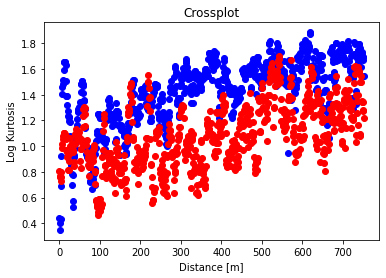

In [ ]:
scatter(df, "D", "logAp", xlabel="Distance [m]", ylabel="Log Kurtosis")
scatter(df, "D", "logAs", xlabel="Distance [m]", ylabel="Log Kurtosis", marker_color="red")
# plt.xlim(0,300)

In [ ]:
M1 = 4.3
M2 = 2.8
M3 = 1.4
M4 = 1.3
M5 = 1.3
M6 = 0.8
M7 = 1.4
M8 = 3.1

In [ ]:
file1 = "/content/PS_HWC_file1 (2).csv"
# file2 = "/content/PS_HWC_file2.csv"
file3 = "/content/PS_HWC_file3.csv"
file45 = "/content/PS_HWC250_file4+5.csv"
# file6 = "/content/PS_HWC_file6.csv"
# file7 = "/content/PS_HWC_file7.csv"

In [ ]:
# df = pd.read_csv(file1)
# df2 = pd.read_csv(file2)
df = pd.read_csv(file45)
# df45 = pd.read_csv(file45)
# df6 = pd.read_csv(file6)
# df7 = pd.read_csv(file7)

In [ ]:
df["tsmintp"] = df.t2 - df.t1
df["Ap/As"] = df.A1 / df.A2
df["logAp"] = np.log10(df.A1)
df["logAs"] = np.log10(df.A2)
# df["sqrtAp"] = np.sqrt(df.Ap)
# df["sqrtAs"] = np.sqrt(df.As)

df

,D,t1,A1,t2,A2,tsmintp,Ap/As,logAp,logAs
0,0.000000,59.128,3.426631,63.992,3.212628,4.864,1.066613,0.534867,0.506860
1,1.020952,59.117,3.377996,63.993,2.437808,4.876,1.385669,0.528659,0.386999
2,2.041905,59.147,0.467748,63.995,1.137874,4.848,0.411072,-0.329988,0.056094
3,3.062857,59.147,0.422821,64.539,1.121931,5.392,0.376869,-0.373843,0.049966
4,4.083810,59.146,0.230603,64.539,1.219346,5.393,0.189120,-0.637135,0.086127
...,...,...,...,...,...,...,...,...,...
272,277.699048,59.134,3.025485,64.021,10.721478,4.887,0.282189,0.480795,1.030255
273,278.720001,59.131,1.663842,64.084,8.127698,4.953,0.204713,0.221112,0.909968
274,279.740953,59.131,4.107102,64.084,9.160776,4.953,0.448336,0.613536,0.961932
275,280.761906,59.213,6.712976,64.083,9.525960,4.870,0.704703,0.826915,0.978909


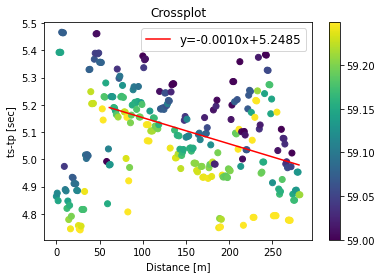

In [ ]:
scatter(df, "D", "tsmintp", "t1", xlabel="Distance [m]", ylabel="ts-tp [sec]", 
        regression=True, start_id=60, end_id=-1)

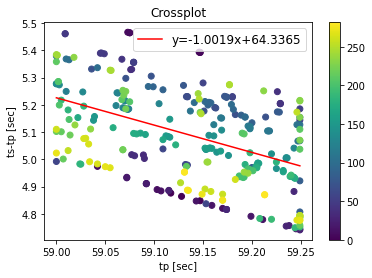

In [ ]:
scatter(df, "t1", "tsmintp", "D", xlabel="tp [sec]", ylabel="ts-tp [sec]", 
        regression=True, start_id=60, end_id=-1)

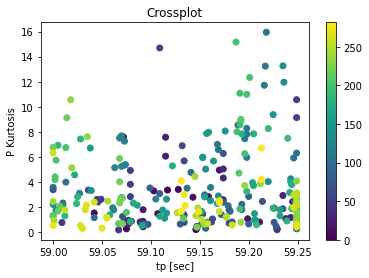

In [ ]:
scatter(df, "t1", "A1", "D", xlabel="tp [sec]", ylabel="P Kurtosis")

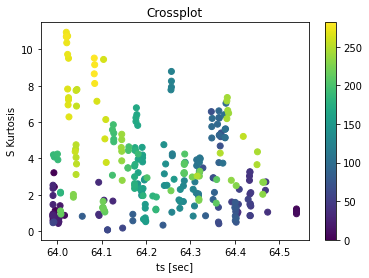

In [ ]:
scatter(df, "t2", "A2", "D", xlabel="ts [sec]", ylabel="S Kurtosis")

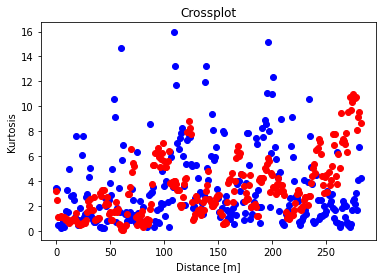

In [ ]:
scatter(df, "D", "A1", xlabel="Distance [m]", ylabel="Kurtosis")
scatter(df, "D", "A2", xlabel="Distance [m]", ylabel="Kurtosis", marker_color="red")

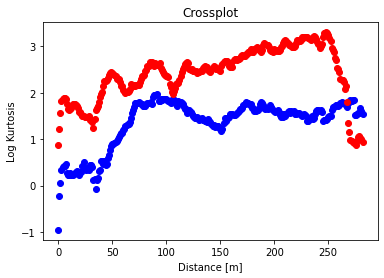

In [ ]:
scatter(df, "D", "logAp", xlabel="Distance [m]", ylabel="Log Kurtosis")
scatter(df, "D", "logAs", xlabel="Distance [m]", ylabel="Log Kurtosis", marker_color="red")